# Etude de la volatilité historique d'actifs et de son comportement dans diverses situations

Il s'agit dans cette partie d'observer comment la volatilité réagit à divers évènements, conditions et facteurs. Ainsi, il semble intéressant de questionner ce qui influence la volatilité, comment réagit-elle en fonction de l'actif et des conditions de marché. 

### Installation des bibliothèques 

In [ ]:
!pip install matplotlib 
!pip install yfinance
!pip install --upgrade nbdime

### Importation des bibliothèques/fonctions utiles 

In [246]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import markdown
import pandas_datareader as pdr
import itertools
import seaborn as sns
from py_vollib.black_scholes import black_scholes

## Fonctions utiles :

In [243]:
def calcul_vol(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Returns'] = data['Close'].pct_change()
        data = data.dropna()
        volatilite = data['Returns'].std()
        return volatilite
        
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
        return None

def calculate_rolling_volatility(ticker, start, end, window_size=20):
    data = yf.download(ticker, start=start, end=end, progress=False)
    data['Daily Returns'] = data['Close'].pct_change()
    rolling_volatility = data['Daily Returns'].rolling(window=window_size).std()
    return rolling_volatility

def calcul_volatilite(ticker, debut, fin, mois):
    try:
        data = yf.download(ticker, start=debut, end=fin)
        data['Returns'] = data['Close'].pct_change()
        data = data.dropna()

        if mois == 0:
            # Volatilité quotidienne
            volatilite = data['Returns'].rolling(window=20).std()
        else:
            # Filtrer les données pour le mois spécifié
            data_mois = data[data.index.month == mois]
            volatilite = data_mois['Returns'].rolling(window=5).std()

        return volatilite
        
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
        return None

""" La première, deuxième, troisième fonctions permettent de calculer la volatilité historique à partir des données yfinance (on rajoute un caractère "glissant" sur la deuxième et un critère de mois sur la troisième).  
Ici les entrées sont des chaines de caractères (str) sauf pour le mois ainsi que window_size qui sont des entiers (int). Window_size représente la taille de la fenêtre pour le calcul de la moyenne glissante (ici 20jours)."""

def calculate_returns(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Returns'] = data['Close'].pct_change()
        data = data.dropna()
        return data[['Close', 'Returns']]
        
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")
        return None

""" La quatrième fonction permet de calculer des rendements mensuels d'un actif à partir des données de yfinance.  
Ici les entrées sont des chaines de caractères (str)."""

def plot_vol(ticker, start_date, end_date):
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        data['Returns'] = data['Close'].pct_change()
        data = data.dropna()
        data['Volatility'] = data['Returns'].rolling(window=20).std()  

        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data['Volatility'], label=f'Volatilité - {ticker}')
        plt.title('Volatilité au fil du temps')
        plt.xlabel('Date')
        plt.ylabel('Volatilité')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Une erreur s'est produite : {e}")

"""La dernière fonction permet de générer le graphe retraçant la volatilité sur une moyenne mobile de 20jours. 
Ici les entrées sont des chaines de caractères (str)."""

## Etude de l'évolution de la volatilité d'actifs en fonction du taux d'intérêt :

Nous utilisons ici le taux d'intérêt américian (T-bill 13week) ainsi que le S&P500

[*********************100%%**********************]  1 of 1 completed


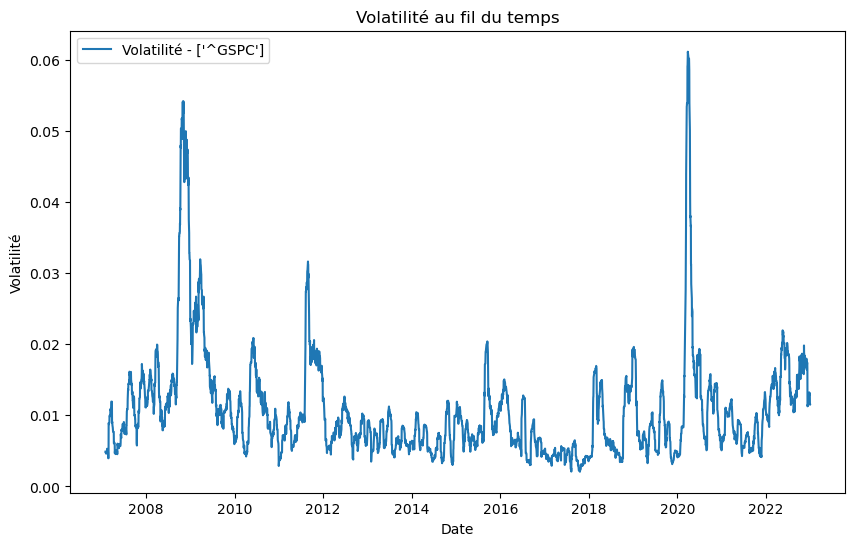

            FEDFUNDS
DATE                
2007-01-01      5.25
2007-02-01      5.26
2007-03-01      5.26
2007-04-01      5.25
2007-05-01      5.25


<Axes: title={'center': "Taux d'Intérêt au fil du temps"}, xlabel='Date', ylabel="Taux d'Intérêt">

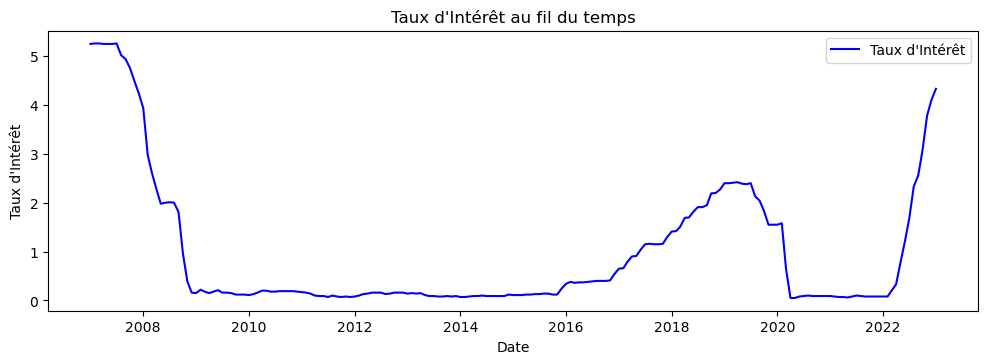

In [193]:
start_date = "2007-01-01"
end_date = "2023-01-01"
ticker = ["^GSPC"]
A = np.array(list(range(int(debut[:4]), int(fin[:4]))))
V = []
plot_vol(ticker, start_date, end_date)

try:
    tx_fed_funds = pdr.get_data_fred('FEDFUNDS', start=debut, end=fin)
    print(tx_fed_funds.head())
   
    tx_fed_funds.to_csv('tx_fed_funds.csv')
except Exception as e:
    print(f"Erreur lors de la récupération des données de taux d'intérêt : {e}")

#Traçage des graphiques 
merged_data = pd.merge(tx_fed_funds, data_volatilite, how='outer', left_index=True, right_index=True)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(merged_data['FEDFUNDS'], label='Taux d\'Intérêt', color='blue')
plt.title('Taux d\'Intérêt au fil du temps')
plt.xlabel('Date')
plt.ylabel('Taux d\'Intérêt')
plt.legend()
plt.subplot(2, 1, 1)


Il apparait donc que pour le S&P500, la volatilité ne corrobore pas nécessairement avec le taux d'intérêt. En effet, bien que ces derniers semblent avoir un comportement opposé, il est important de garder en mémoire que la volatilité dépend d'un grand nombre de facteur tels que les anticipations économiques, les conditions macroéconomiques, ou encore la liquidité des marchés. De fait, il est difficile d'affirmer un lien entre ces deux éléments, bien que l'on puisse toutefois observer une réelle opposition dans les comportements des deux courbes.

## Realisation d'un correlogramme entre taux d'intérêt et volatilité 

Nous reprenons ici les mêmes indices que précédemment : 

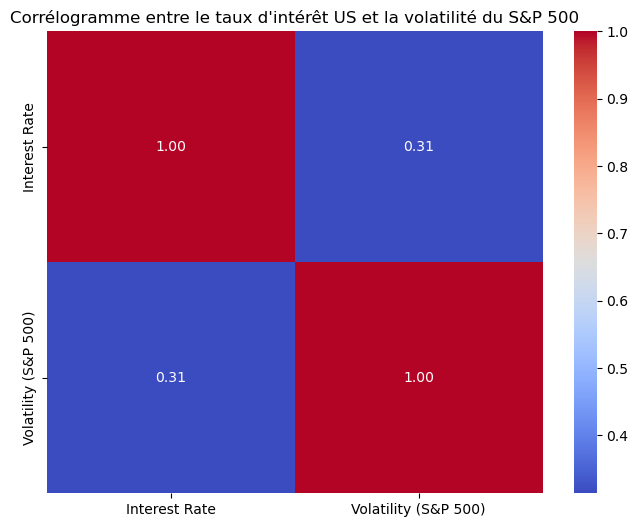

In [247]:
# Fonction pour récupérer les données
def get_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end, progress=False)
    return data['Close']

start_date = "2010-01-01"
end_date = "2022-01-01"
interest_rate_ticker = "^IRX"  
volatility_ticker = "^GSPC"  

# Récupération des données et calcul de la correlation 
interest_rate_data = get_data(interest_rate_ticker, start_date, end_date)
volatility_data = get_data(volatility_ticker, start_date, end_date)
df = pd.DataFrame({'Interest Rate': interest_rate_data, 'Volatility (S&P 500)': volatility_data})
correlation_matrix = df.corr()

# Création du correlogramme avec Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Corrélogramme entre le taux d\'intérêt US et la volatilité du S&P 500')
plt.show()


Il apparait donc qu'il y ait une corrélation positive - bien que relativement faible (0.31) - entre le taux d'intérêt et la volatilité pour les stocks observés.

## Etude de la volatilité pour deux actifs fortement corrélés (ici Pespi et Coca-Cola) :

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


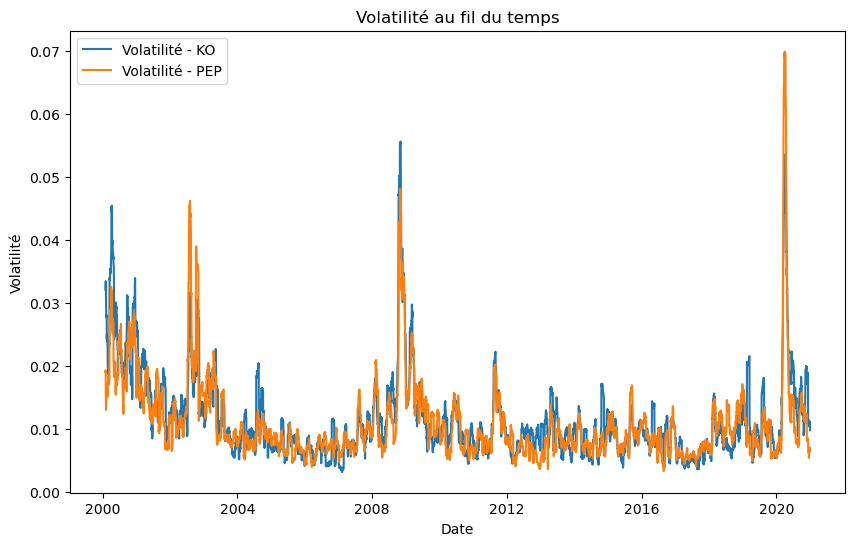

In [253]:
tickers = ["KO", "PEP"]
start_date = "2000-01-01"
end_date = "2020-12-31"

plt.figure(figsize=(10, 6))

# Calcul de la volatilité de chaque ticker sur une fenêtre mobile de 20 jours.
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Returns'] = data['Close'].pct_change()
    data = data.dropna()
    data['Volatility'] = data['Returns'].rolling(window=20).std()
    plt.plot(data.index, data['Volatility'], label=f'Volatilité - {ticker}')

#Traçage des graphiques
plt.title('Volatilité au fil du temps')
plt.xlabel('Date')
plt.ylabel('Volatilité')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


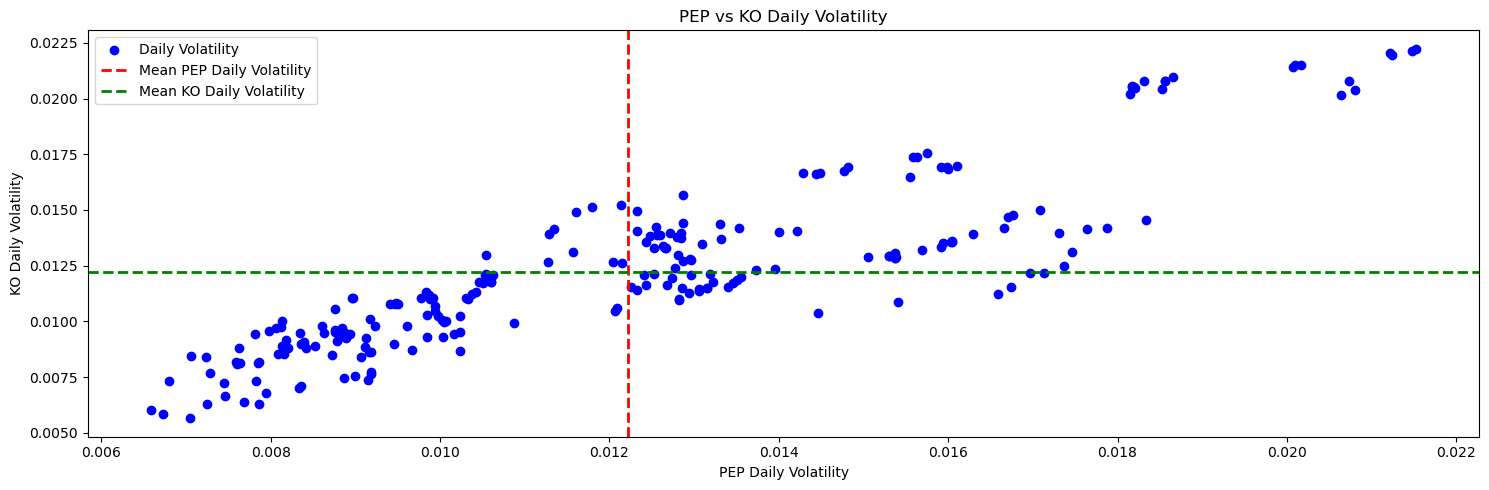

In [265]:
import matplotlib.pyplot as plt
import yfinance as yf
import itertools

def calculate_daily_volatility(data):
    returns = data['Adj Close'].pct_change().dropna()
    daily_volatility = returns.rolling(window=20).std()  
    return daily_volatility

# Calcul des volatilités des tickers choisis
pep_data = yf.download("PEP", start="2022-01-01", end="2023-01-01")
ko_data = yf.download("KO", start="2022-01-01", end="2023-01-01")
pep_daily_volatility = calculate_daily_volatility(pep_data)
ko_daily_volatility = calculate_daily_volatility(ko_data)

# Création des scatterplots comparant la volatilité des stocks (les pointillés représentent la moyenne du stock)
stock_combinations = list(itertools.combinations(['PEP', 'KO'], 2))
fig, axs = plt.subplots(1, len(stock_combinations), figsize=(15, 5), squeeze=False) 

for i, combination in enumerate(stock_combinations):
    stock1, stock2 = combination
    ax = axs[0, i]  # Accéder à l'axe dans le tableau bidimensionnel
    ax.scatter(locals()[f'{stock1.lower()}_daily_volatility'], locals()[f'{stock2.lower()}_daily_volatility'], label='Daily Volatility', color='blue', marker='o')
    ax.axvline(locals()[f'{stock1.lower()}_daily_volatility'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean {stock1} Daily Volatility')
    ax.axhline(locals()[f'{stock2.lower()}_daily_volatility'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean {stock2} Daily Volatility')
    ax.set_title(f'{stock1} vs {stock2} Daily Volatility')
    ax.set_xlabel(f'{stock1} Daily Volatility')
    ax.set_ylabel(f'{stock2} Daily Volatility')
    ax.legend()

plt.tight_layout()
plt.show()


Les volatilités de deux actifs corrélés semblent dès lors en être de même. Cela se vérifie bien avec le scatterplot qui met en exergue une correlation des volatilités. La similarité de la volatilité peut également créer des opportunités de trading. Les traders peuvent tirer parti des mouvements de prix prévisibles entre les deux actifs en fonction de leurs relations de corrélation historiques. De plus, dans le cas de forte disparité de volatilité, les traders peuvent anticiper/parier sur un retour à la moyenne. Néanmoins, la correlation de ces deux actifs peut entrainer des problèmes de diversifications de portefeuilles et donc de gestion du risque.

## Etude du "January Effect" en finance : 

Le "January effect" est un phénomène financier faisant référence à la hausse des prix des actions et à la relative hausse des rendements financiers lors de cette période de l'année. 

Il semblait donc intéressant de questionner la volatilité et ses tendances sur les mois de janvier, comparée aux autres mois de l'année. Plus encore, il s'agit de vérifier dans un premier temps si les rendements sont plus aventageux en janvier que le reste du temps, puis de se questionner sur l'existence d'un lien avec la volatilité : comment le marché réagit à cette hausse potentielle de rendement, ce dernier est-il plus ou moins volatil que durant les autres mois ?

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


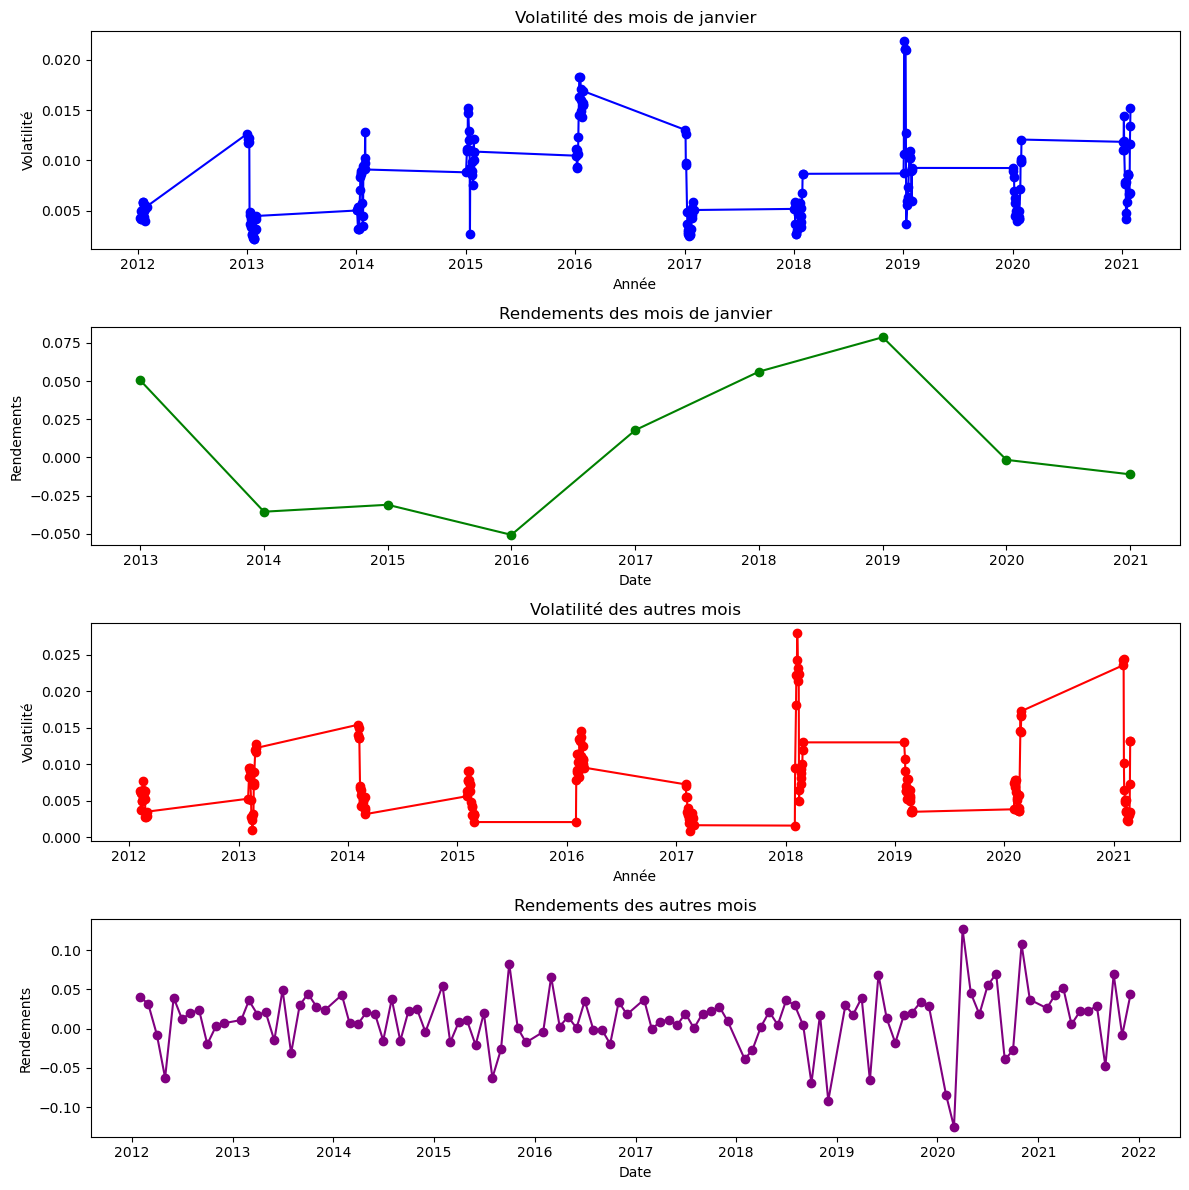

In [232]:
debut = "2012-01-01"
fin = "2022-01-01"
ticker = "^GSPC"

#calcul des volatilité et rendements 
january_volatility = calcul_volatilite(ticker, debut, fin, mois=1)
january_returns = calcul_returns(ticker, debut, fin)
january_returns = january_returns[january_returns.index.month == 1]
other_month_volatility = calcul_volatilite(ticker, debut, fin, mois=2)
other_month_returns = calcul_returns(ticker, debut, fin)
other_month_returns = other_month_returns[other_month_returns.index.month != 1]

#Traçage des graphiques
plt.figure(figsize=(12, 12))

plt.subplot(4, 1, 1)
plt.plot(january_volatility.index, january_volatility, marker='o', linestyle='-', color='blue')
plt.title('Volatilité des mois de janvier')
plt.xlabel('Année')
plt.ylabel('Volatilité')
plt.subplot(4, 1, 2)
plt.plot(january_returns.index, january_returns, marker='o', linestyle='-', color='green')
plt.title('Rendements des mois de janvier')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.subplot(4, 1, 3)
plt.plot(other_month_volatility.index, other_month_volatility, marker='o', linestyle='-', color='red')
plt.title('Volatilité des autres mois')
plt.xlabel('Année')
plt.ylabel('Volatilité')
plt.subplot(4, 1, 4)
plt.plot(other_month_returns.index, other_month_returns, marker='o', linestyle='-', color='purple')
plt.title('Rendements des autres mois')
plt.xlabel('Date')
plt.ylabel('Rendements')

plt.tight_layout()
plt.show()


Il apparait donc bien que les rendements de janvier soient supérieurs aux rendements des autres mois. Par ailleurs, la volatilité est également supérieure. Cela semble pouvoir s'expliquer par divers éléments. Tout d'abord l'effet de rattrapage : la baisse de la liquidité en décembre, les ajustements de portefeuille, les achats institutionnels et les opérations de rachat de début d'année entrainent des mouvements brusques pouvant favoriser la hausse de la volatilité.

## Observation de la volatilité de plusieurs actifs en fonction d'autres actifs

Nous cherchons ici à observer la représentation que peut prendre un graphe de volatilité utilisant un scatterplot. Cela peut nous permettre de visualiser davantage la concentration de point, d'évaluer aussi la dispersion et donc finalement peut offrir un autre moyen d'observer une correlation entre deux titres, simultanément.

Ici nous choisissons un actif réputé comme stable (Procter&Gamble), un actif réputé comme plus volatil (Tesla) et enfin un dernier actif "neutre" (Microsoft).

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


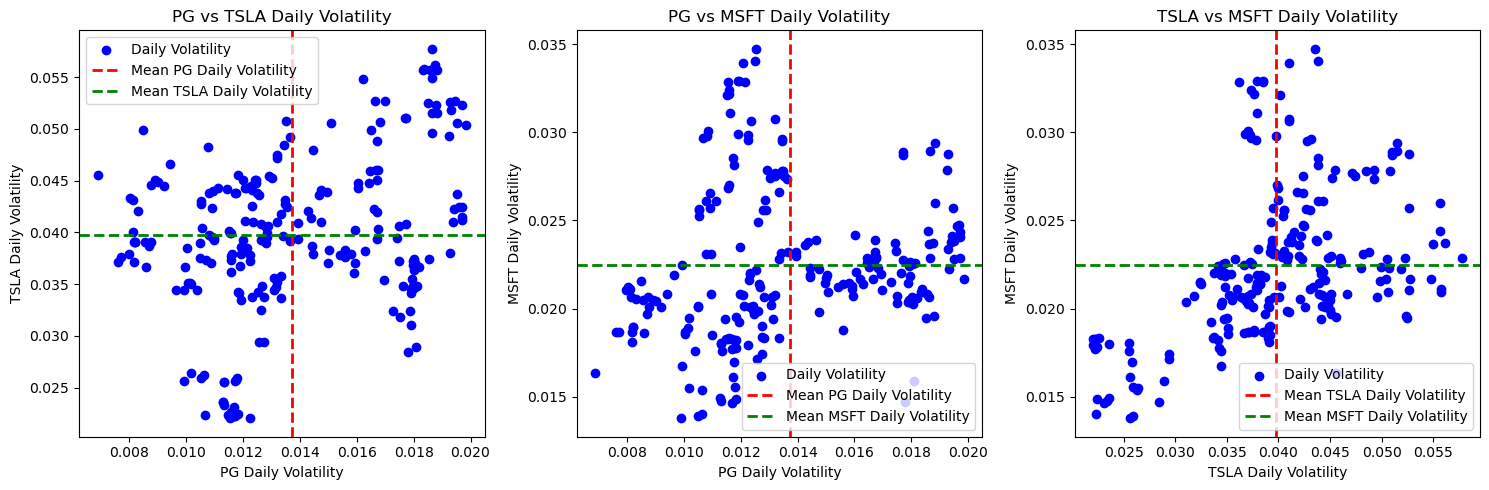

In [264]:
def calculate_daily_volatility(data):
    returns = data['Adj Close'].pct_change().dropna()
    daily_volatility = returns.rolling(window=21).std()
    return daily_volatility

# Téléchargement des données pour les tickers choisis
pg_data = yf.download("PG", start="2022-01-01", end="2023-01-01")
tsla_data = yf.download("TSLA", start="2022-01-01", end="2023-01-01")
msft_data = yf.download("MSFT", start="2022-01-01", end="2023-01-01")  # Remplacement d'AAPL par MSFT
pg_daily_volatility = calculate_daily_volatility(pg_data)
tsla_daily_volatility = calculate_daily_volatility(tsla_data)
msft_daily_volatility = calculate_daily_volatility(msft_data)  # Remplacement d'aapl_daily_volatility par msft_daily_volatility

# Création des scatterplots comparant la volatilité des stocks (les pointillés représentent la moyenne du stock)
stock_combinations = list(itertools.combinations(['PG', 'TSLA', 'MSFT'], 2))  # Remplacement de 'AAPL' par 'MSFT'
fig, axs = plt.subplots(1, len(stock_combinations), figsize=(15, 5))

for i, combination in enumerate(stock_combinations):
    stock1, stock2 = combination
    axs[i].scatter(locals()[f'{stock1.lower()}_daily_volatility'], locals()[f'{stock2.lower()}_daily_volatility'], label='Daily Volatility', color='blue', marker='o')
    axs[i].axvline(locals()[f'{stock1.lower()}_daily_volatility'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean {stock1} Daily Volatility')
    axs[i].axhline(locals()[f'{stock2.lower()}_daily_volatility'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean {stock2} Daily Volatility')
    axs[i].set_title(f'{stock1} vs {stock2} Daily Volatility')
    axs[i].set_xlabel(f'{stock1} Daily Volatility')
    axs[i].set_ylabel(f'{stock2} Daily Volatility')
    axs[i].legend()

plt.tight_layout()
plt.show()


Il apparait bien ici que la correlation entre les volatilités évolue en fonction du types d'actifs choisi. Pour PG et TSLA, les deux actifs ont des volatilités réputées différentes ainsi le scatterplot ne souligne pas de lien particulier. Pour PG et Microsoft, une correlation se devine mais là encore relativement faible. En revanche pour deux actifs avec une volatilité "élevée" pour l'un et "neutre" pour l'autre (comme c'est le cas pour TSLA et MSFT), il semble avoir un rapport plus marqué au niveau de leur volatilité, comme le souligne le scatterplot correspondant. 

## Effet du contexte géopolitique sur certains stocks et leur volatilité : 

Il semble en effet intéressant de questionner la volatilité des actifs en période de guerre ou de crise.

Pour cela, nous choisissons les 4 actifs suivants : Agrogeneration est un producteur de blé implanté en Ukraine. A l'inverse Adeocagro est un produteur de blé implanté en Amérique du Sud. Pour gagner en représentation, nous ajoutons également un armateur (Northrop Grumman Corporation) et une entreprise d'un secteur différent (Google). Nous souhaitons ici nous concentrer sur la période relative à la guerre en Ukraine (2021-2023). Nous prenons un intervalle de 2 ans, et comparons avec un intervalle hors période de guerre (2015-2017). 

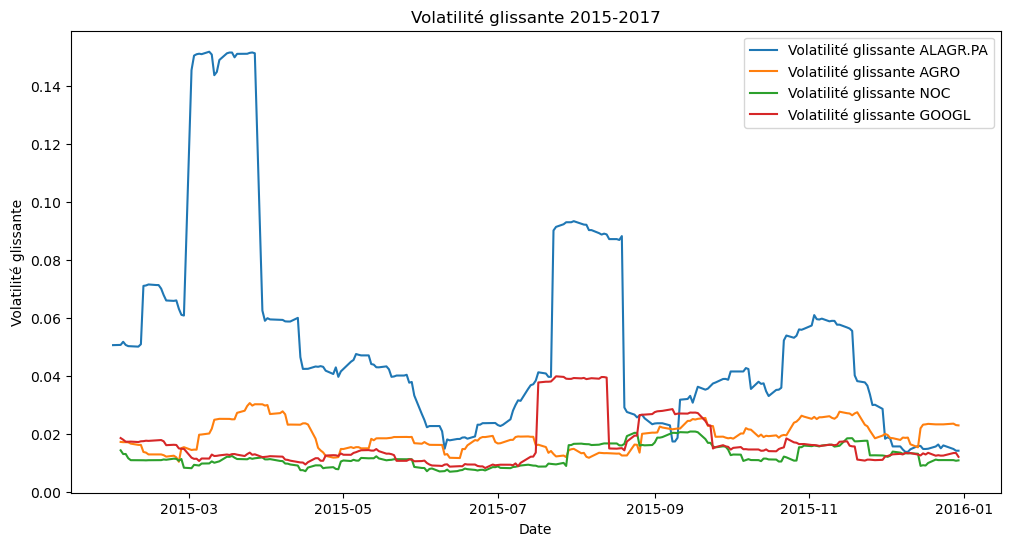

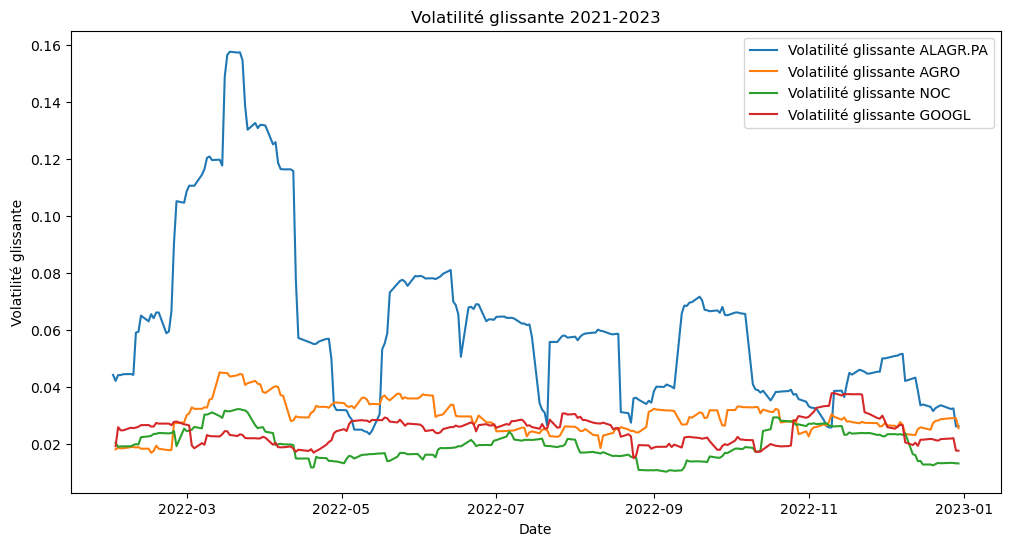

In [257]:
#Calcul de la volatilité glissante et traçage des graphiques sur la période 1 
start_date = "2015-01-01"
end_date = "2015-12-31"  
ticker_agrogeneration = "ALAGR.PA"  
ticker_adecoagro = "AGRO"  
ticker_noc = "NOC"  
ticker_googl = "GOOGL"  

rolling_volatility_agrogeneration = calculate_rolling_volatility(ticker_agrogeneration, start_date, end_date)
rolling_volatility_adecoagro = calculate_rolling_volatility(ticker_adecoagro, start_date, end_date)
rolling_volatility_noc = calculate_rolling_volatility(ticker_noc, start_date, end_date)
rolling_volatility_googl = calculate_rolling_volatility(ticker_googl, start_date, end_date)

plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility_agrogeneration.index, rolling_volatility_agrogeneration, label=f"Volatilité glissante {ticker_agrogeneration}")
plt.plot(rolling_volatility_adecoagro.index, rolling_volatility_adecoagro, label=f"Volatilité glissante {ticker_adecoagro}")
plt.plot(rolling_volatility_noc.index, rolling_volatility_noc, label=f"Volatilité glissante {ticker_noc}")
plt.plot(rolling_volatility_googl.index, rolling_volatility_googl, label=f"Volatilité glissante {ticker_googl}")
plt.title('Volatilité glissante 2015-2017')
plt.xlabel('Date')
plt.ylabel('Volatilité glissante')
plt.legend()
plt.show()

#Calcul de la volatilité glissante et traçage des graphiques sur la période 2 
start_date = "2022-01-01"
end_date = "2022-12-31"  
ticker_agrogeneration = "ALAGR.PA"  
ticker_adecoagro = "AGRO"  
ticker_noc = "NOC"  
ticker_googl = "GOOGL"  

rolling_volatility_agrogeneration = calculate_rolling_volatility(ticker_agrogeneration, start_date, end_date)
rolling_volatility_adecoagro = calculate_rolling_volatility(ticker_adecoagro, start_date, end_date)
rolling_volatility_noc = calculate_rolling_volatility(ticker_noc, start_date, end_date)
rolling_volatility_googl = calculate_rolling_volatility(ticker_googl, start_date, end_date)

plt.figure(figsize=(12, 6))
plt.plot(rolling_volatility_agrogeneration.index, rolling_volatility_agrogeneration, label=f"Volatilité glissante {ticker_agrogeneration}")
plt.plot(rolling_volatility_adecoagro.index, rolling_volatility_adecoagro, label=f"Volatilité glissante {ticker_adecoagro}")
plt.plot(rolling_volatility_noc.index, rolling_volatility_noc, label=f"Volatilité glissante {ticker_noc}")
plt.plot(rolling_volatility_googl.index, rolling_volatility_googl, label=f"Volatilité glissante {ticker_googl}")
plt.title('Volatilité glissante 2021-2023')
plt.xlabel('Date')
plt.ylabel('Volatilité glissante')
plt.legend()
plt.show()


Si la volatilité du producteur de blé ukrainien semble augmenter mais reste en permanence élevée, celle du producteur latino-américain augmente plus significativement en période de conflit qu'en période de paix. Il apparait également que la volatilité de l'armateur est relativement plus stable que celle de Google. Du moins, il apparait bien qu'il y a une différence d'écart de volatilité plus significative entre les deux stocks sur la période touchée par la guerre ukrainienne, qu'entre ces même stocks sur une période réputée plus calme. 
Ainsi, il apparait bien que le cours des actions et leur volatilité soient directement impactés par des évènements géopolitiques. De plus, ces graphes mettent aussi en évidence que toutes les entreprises ne sont pas impactées par ce phénomène, notamment du fait de leur secteur et géographie d'activité.